In [2]:
!pip install datasets

In [3]:
import datasets
print(datasets.__version__)

4.0.0


In [4]:
from datasets import load_dataset

dataset = load_dataset("thisisanshgupta/CodeAlpaca")
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

code_alpaca_20k.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/20022 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['output', 'instruction', 'input'],
        num_rows: 20022
    })
})


In [5]:
for i in range(3):
    print(f"--- Sample {i+1} ---")
    print("INSTRUCTION:", dataset['train'][i]['instruction'])
    print("INPUT:", dataset['train'][i]['input'])
    print("OUTPUT:", dataset['train'][i]['output'])
    print()

--- Sample 1 ---
INSTRUCTION: Create an array of length 5 which contains all even numbers between 1 and 10.
INPUT: 
OUTPUT: arr = [2, 4, 6, 8, 10]

--- Sample 2 ---
INSTRUCTION: Formulate an equation to calculate the height of a triangle given the angle, side lengths and opposite side length.
INPUT: 
OUTPUT: Height of triangle = opposite side length * sin (angle) / side length

--- Sample 3 ---
INSTRUCTION: Write a replace method for a string class which replaces the given string with a given set of characters.
INPUT: string = "Hello World!"
replace_with = "Greetings!"
OUTPUT: def replace(self, replace_with):
    new_string = ""
    for char in self:
        if char == " ":
            new_string += replace_with
        else:
            new_string += char
    return new_string



In [6]:
print("Total samples:", len(dataset['train']))
print("Column names:", dataset['train'].column_names)

Total samples: 20022
Column names: ['output', 'instruction', 'input']


In [35]:
from collections import Counter

def label_sample(instruction):
    instruction = instruction.lower()

    if any(w in instruction for w in [
        "extract", "find all", "list all", "get all", "retrieve",
        "parse", "return all", "fetch", "pull out", "identify all",
        "print all", "count all"
    ]):
        return "extraction"

    elif any(w in instruction for w in [
        "debug", "fix", "bug", "error", "why", "analyze", "analyse",
        "explain", "what is", "what are", "describe", "how does",
        "what happens", "what will", "output", "rewrite", "clean up",
        "edit", "modify", "improve", "optimize", "refactor", "purpose",
        "difference between", "compare", "what do"
    ]):
        return "reasoning"

    else:
        return "qa"

labels = [label_sample(item['instruction']) for item in dataset['train']]
print(Counter(labels))

Counter({'qa': 16216, 'reasoning': 2785, 'extraction': 1021})


In [12]:
qa_samples = []
reasoning_samples = []
extraction_samples = []

for item in dataset['train']:
    label = label_sample(item['instruction'])

    if label == 'qa':
        qa_samples.append(item)
    elif label == 'reasoning':
        reasoning_samples.append(item)
    elif label == 'extraction':
        extraction_samples.append(item)

print("QA samples collected:", len(qa_samples))
print("Reasoning samples collected:", len(reasoning_samples))
print("Extraction samples collected:", len(extraction_samples))

QA samples collected: 16216
Reasoning samples collected: 2785
Extraction samples collected: 1021


In [36]:
import random
random.seed(42)

qa        = random.sample(qa_samples, 400)
reasoning  = random.sample(reasoning_samples, 400)
extraction = random.sample(extraction_samples, 400)

# Combine all together
all_selected = qa + reasoning + extraction

# Shuffle so they're not grouped by type
random.shuffle(all_selected)

print("Selected QA:", len(qa))
print("Selected Reasoning:", len(reasoning))
print("Selected Extraction:", len(extraction))
print("Total combined:", len(all_selected))

Selected QA: 400
Selected Reasoning: 400
Selected Extraction: 400
Total combined: 1200


In [14]:
# 90% train, 10% val
split_index = int(len(all_selected) * 0.9)

train_data = all_selected[:split_index]
val_data   = all_selected[split_index:]

print("Train samples:", len(train_data))
print("Val samples:  ", len(val_data))

Train samples: 1080
Val samples:   120


In [41]:
import json
import os

# Create data folder
os.makedirs("data", exist_ok=True)

# Save train.jsonl
with open("data/train.jsonl", "w") as f:
    for sample in train_data:
        f.write(json.dumps({
            "instruction": sample["instruction"],
            "input": sample["input"],
            "output": sample["output"]
        }) + "\n")

# Save val.jsonl
with open("data/val.jsonl", "w") as f:
    for sample in val_data:
        f.write(json.dumps({
            "instruction": sample["instruction"],
            "input": sample["input"],
            "output": sample["output"]
        }) + "\n")

print("train.jsonl saved with", len(train_data), "samples")
print("val.jsonl saved with", len(val_data), "samples")

train.jsonl saved with 1080 samples
val.jsonl saved with 120 samples


In [16]:
!ls data

train.jsonl  val.jsonl


In [39]:
import json
import numpy as np

def estimate_tokens(text):
    return max(1, len(text) // 4)

def get_tokens(filepath):
    tokens = []
    with open(filepath) as f:
        for line in f:
            s = json.loads(line)
            tokens.append(estimate_tokens(s["instruction"] + s["input"] + s["output"]))
    return tokens

train_tokens = get_tokens("data/train.jsonl")
val_tokens   = get_tokens("data/val.jsonl")

for name, tokens in [("TRAIN", train_tokens), ("VAL", val_tokens)]:
    print(f"\n=== {name} ===")
    print(f"Samples : {len(tokens)}")
    print(f"Mean    : {np.mean(tokens):.1f}")
    print(f"Median  : {np.median(tokens):.1f}")
    print(f"Min     : {np.min(tokens)}")
    print(f"Max     : {np.max(tokens)}")
    print(f"Outliers: {sum(1 for t in tokens if t > 512)}")


=== TRAIN ===
Samples : 1080
Mean    : 73.8
Median  : 60.0
Min     : 8
Max     : 431
Outliers: 0

=== VAL ===
Samples : 120
Mean    : 72.5
Median  : 58.0
Min     : 15
Max     : 296
Outliers: 0


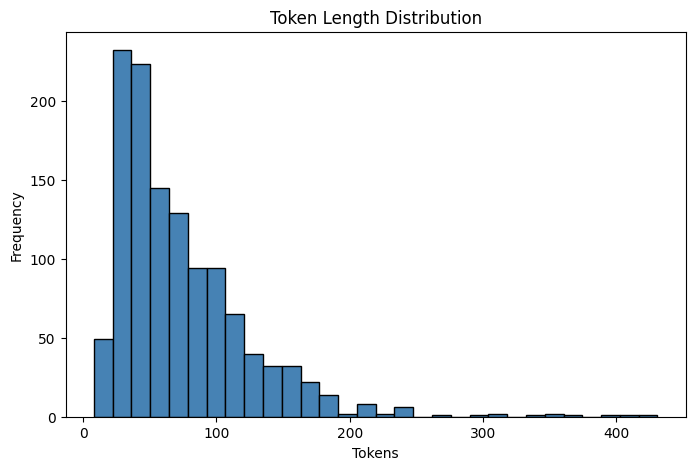

In [40]:
import matplotlib.pyplot as plt

all_tokens = train_tokens + val_tokens

plt.figure(figsize=(8, 5))
plt.hist(all_tokens, bins=30, color='steelblue', edgecolor='black')
plt.title("Token Length Distribution")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.savefig("token_distribution.png", dpi=300)
plt.show()

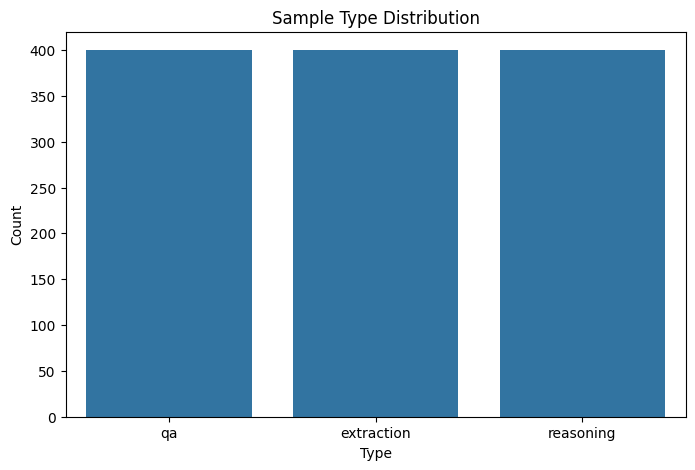

In [44]:
import seaborn as sns

labels = [label_sample(s['instruction']) for s in all_selected]

plt.figure(figsize=(8, 5))
sns.countplot(x=labels)
plt.title("Sample Type Distribution")
plt.xlabel("Type")
plt.ylabel("Count")
plt.savefig("type_distribution.png", dpi=300)
plt.show()